## Mounting Drive, Loading and Shaping Inputs

In [ ]:
#mount Drive and establish path
from google.colab import drive                            #set up file locations !! This needs to be adapted for different accounts
drive.mount('/content/drive',force_remount=True)          #mount drive
%cd /content/drive/MyDrive/Colab\ Notebooks/CCH-AE\ Paper/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/CCH-AE Paper


In [ ]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/CCH-AE Paper'

In [ ]:
#import libraries and datasets
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras import Input, Model
from keras.datasets import mnist
import torch
import scipy as scipy
import statistics
from scipy.optimize import least_squares

In [ ]:
#importing and shaping input training/testing data
mat = scipy.io.loadmat('data/SheppLoganData.mat')                  #read in compiled input mat file
mat.keys()                                                              #find file headers
input_train = mat['input_train']                                        #shape (10000, 45, 36)
print(input_train.shape)
input_test = mat['input_test']                                          #shape (2000, 45, 36)
print(input_test.shape) 
target_train = mat['target_train']                                      #shape (10000, 32, 32)
print(target_train.shape)
target_test = mat['target_test']                                        #shape (2000, 32, 32)
print(target_test.shape)
A = mat['A']
print(A.shape)

(10000, 45, 36)
(2000, 45, 36)
(10000, 32, 32)
(2000, 32, 32)
(1620, 1024)


In [ ]:
n_train = input_train.shape[0]                                      #10000
print(n_train)
n_test = input_test.shape[0]                                        #2000
print(n_test)

input_size = (input_train.shape[1], input_train.shape[2])           #(45, 36)
print(input_size)
input_length =  input_size[0] * input_size[1]                       #1620
print(input_length)
target_size = (target_train.shape[1], target_train.shape[2])        #(32, 32)
print(target_size)
target_length = target_size[0] * target_size[1]                     #1024
print(target_length)


10000
2000
(45, 36)
1620
(32, 32)
1024


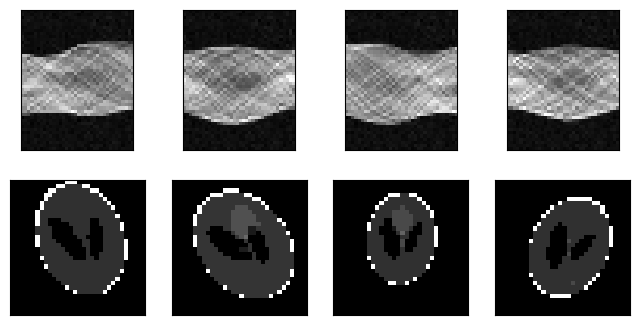

In [ ]:
# Showing example images from input and target
plt.figure(figsize=(8, 4))
plt.gray()
EXS = 4
for j in range(EXS):
    i = random.randint(0,n_test-1)
    ax = plt.subplot(2,EXS, j + 1)
    plt.imshow(input_train[i,:,:])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
for j in range(EXS):
    i = random.randint(0,n_test)
    ax = plt.subplot(2,EXS, j + 1 +EXS) 
    plt.imshow(target_train[i,:,:])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('figures/example_data.eps', format='eps')
plt.savefig('figures/example_data.png', format='png')
plt.show()

In [ ]:
# Reshaping training and testing data for input into the network
input_train = input_train.reshape((n_train, input_length),order="F")      #(10000, 1620)
# print(input_train.shape)                  
input_test = input_test.reshape((n_test,input_length),order="F")          #(2000, 1620)
# print(input_test.shape)
target_train = target_train.reshape((n_train,target_length),order="F")    #(10000, 1024)
# print(target_train.shape)
target_test = target_test.reshape((n_test,target_length),order="F")       #(2000, 1024)
# print(target_test.shape)

## Input Autoencoder

In [ ]:
#creating two layer encoder/decoder model
#   decoder(encoder(x)) -> autoencoder(x)

#define dimension of the latent space and inner dimension for the second layer
latent_dim = 15
inner_dim = int((input_length+latent_dim)/2)

#establish architecture of the encoder
encoder_input = keras.Input(shape = input_length, name = 'original_image')
inner_encoded = layers.Dense(inner_dim, activation = 'relu', 
                             activity_regularizer = keras.regularizers.l1(10e-6),
                             kernel_initializer='random_normal',
                             bias_initializer='zeros')(encoder_input)
encoder_output = layers.Dense(latent_dim, activation = 'linear',
                              activity_regularizer = keras.regularizers.l1(10e-6),
                              kernel_initializer='random_normal',
                              bias_initializer='zeros')(inner_encoded)

encoder = keras.Model(encoder_input, encoder_output, name = 'encoder')
encoder.summary()

#establish architecture of the decoder
decoder_input = keras.Input(shape = latent_dim, name = 'encoded_image')
inner_decoded = layers.Dense(inner_dim, activation = 'relu',
                             activity_regularizer = keras.regularizers.l1(10e-6),
                             kernel_initializer='random_normal',
                             bias_initializer='zeros')(decoder_input)
decoder_output = layers.Dense(input_length, activation = 'sigmoid',
                              activity_regularizer = keras.regularizers.l1(10e-6),
                              kernel_initializer='random_normal',
                              bias_initializer='zeros')(inner_decoded)
decoder = keras.Model(decoder_input, decoder_output, name = 'decoder')
decoder.summary()

#create full autoencoder model
autoencoder_input = keras.Input(shape = input_length, name = 'original_image')
encoded_image = encoder(autoencoder_input)
decoded_image = decoder(encoded_image)
autoencoder = keras.Model(autoencoder_input, decoded_image, name = 'autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 original_image (InputLayer)  [(None, 1620)]           0         
                                                                 
 dense (Dense)               (None, 817)               1324357   
                                                                 
 dense_1 (Dense)             (None, 15)                12270     
                                                                 
Total params: 1,336,627
Trainable params: 1,336,627
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoded_image (InputLayer)  [(None, 15)]              0         
                                                                 
 dense_2 (Dense)             (No

In [ ]:
# compiling autoencoder
autoencoder.compile(optimizer='adam', loss= 'binary_crossentropy')       
autoencoder.fit(input_train, input_train,
                epochs=200,
                batch_size=256,
                validation_data=(input_test, input_test))
autoencoder.save('models/SL_ae_in')
encoder.save('models/SL_e_in')
decoder.save('models/SL_d_in')

Epoch 1/200
40/40 [==============================] - 8s 19ms/step - loss: 0.5048 - val_loss: 0.4672
Epoch 2/200
40/40 [==============================] - 0s 8ms/step - loss: 0.4654 - val_loss: 0.4643
Epoch 3/200
40/40 [==============================] - 0s 8ms/step - loss: 0.4620 - val_loss: 0.4604
Epoch 4/200
40/40 [==============================] - 0s 9ms/step - loss: 0.4590 - val_loss: 0.4585
Epoch 5/200
40/40 [==============================] - 0s 8ms/step - loss: 0.4571 - val_loss: 0.4564
Epoch 6/200
40/40 [==============================] - 0s 8ms/step - loss: 0.4546 - val_loss: 0.4538
Epoch 7/200
40/40 [==============================] - 0s 10ms/step - loss: 0.4530 - val_loss: 0.4528
Epoch 8/200
40/40 [==============================] - 0s 8ms/step - loss: 0.4522 - val_loss: 0.4524
Epoch 9/200
40/40 [==============================] - 0s 7ms/step - loss: 0.4516 - val_loss: 0.4520
Epoch 10/200
40/40 [==============================] - 0s 8ms/step - loss: 0.4512 - val_loss: 0.4512
Epoch 1

63/63 [==============================] - 0s 1ms/step


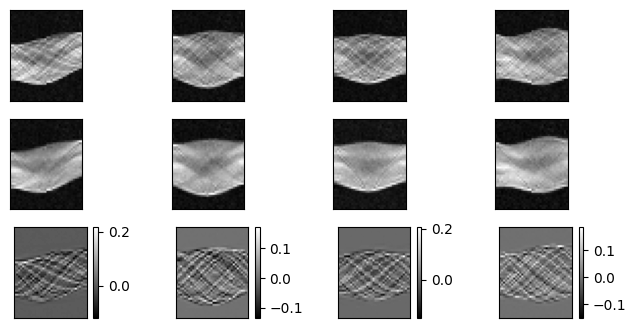

Frobenius Norm of Difference Between Predicted and Target Input
1.494586738979893
1.6206154672557596
1.5584097062907165
1.6211923869681204

Average Error (Fro norm of difference between target and reconstruction)
1.5753651665332409


In [ ]:
# #load bce model from save
autoencoder = keras.models.load_model('models/SL_ae_in')
encoder = keras.models.load_model('models/SL_e_in')
decoder = keras.models.load_model('models/SL_d_in')

EXS = 4
rand_examples = []
for k in range(EXS):
  rand_examples.append(random.randint(0,n_test))

bce_Errs = []
mse_Errs = []

#create and display model output
encoded_img = encoder.predict(input_test)
decoded_img = decoder.predict(encoded_img)
plt.figure(figsize=(8, 4))
for j in range(EXS):
    i = rand_examples[j]
    plt.gray()
    # Display five random original images
    ax = plt.subplot(3, EXS, j + 1)
    plt.imshow(input_test[i].reshape((input_size[0], input_size[1]),order="F"))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display the reconstructions of the five original (autoencoder outputs)
    ax = plt.subplot(3, EXS, j + 1 + EXS)
    plt.imshow(decoded_img[i].reshape((input_size[0], input_size[1]),order="F"))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display five random original images
    ax = plt.subplot(3, EXS, j + 1 + EXS + EXS)
    err = input_test[i].reshape((input_size[0], input_size[1]),order="F")-decoded_img[i].reshape((input_size[0], input_size[1]),order="F")
    plt.imshow(err)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    bce_Errs.append(linalg.norm(err))
    plt.colorbar()
plt.savefig('figures/input_ae.eps', format='eps')    
plt.show()

print('Frobenius Norm of Difference Between Predicted and Target Input')
for i in range(EXS):
  print(str(bce_Errs[i]))

errs = []
for i in range(n_test):
  err = input_test[i].reshape(input_size[0], input_size[1])-decoded_img[i].reshape(input_size[0], input_size[1])
  errs.append(linalg.norm(err))
print('\nAverage Error (Fro norm of difference between target and reconstruction)')
print(statistics.mean(errs))


## Target Autoencoder

In [ ]:
#creating two layer encoder/decoder model
#   decoder(encoder(x)) -> autoencoder(x)

#define dimension of the latent space and inner dimension for the second layer
latent_dim = 15
inner_dim = int((target_length+latent_dim)/2)

#establish architecture of the encoder
encoder_input = keras.Input(shape = target_length, name = 'original_image')
inner_encoded = layers.Dense(inner_dim, activation = 'relu', 
                             activity_regularizer = keras.regularizers.l1(10e-6),
                              kernel_initializer='random_normal',
                              bias_initializer='zeros')(encoder_input)
encoder_output = layers.Dense(latent_dim, activation = 'linear',
                              activity_regularizer = keras.regularizers.l1(10e-6),
                              kernel_initializer='random_normal',
                              bias_initializer='zeros')(inner_encoded)
encoder = keras.Model(encoder_input, encoder_output, name = 'encoder')
encoder.summary()

#establish architecture of the decoder
decoder_input = keras.Input(shape = latent_dim, name = 'encoded_image')
inner_decoded = layers.Dense(inner_dim, activation = 'relu',
                             activity_regularizer = keras.regularizers.l1(10e-6),
                              kernel_initializer='random_normal',
                              bias_initializer='zeros')(decoder_input)
decoder_output = layers.Dense(target_length, activation = 'sigmoid',
                              activity_regularizer = keras.regularizers.l1(10e-6),
                              kernel_initializer='random_normal',
                              bias_initializer='zeros')(inner_decoded)
decoder = keras.Model(decoder_input, decoder_output, name = 'decoder')
decoder.summary()

#create full autoencoder model
autoencoder_input = keras.Input(shape = target_length, name = 'original_image')
encoded_image = encoder(autoencoder_input)
decoded_image = decoder(encoded_image)
autoencoder = keras.Model(autoencoder_input, decoded_image, name = 'autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 original_image (InputLayer)  [(None, 1024)]           0         
                                                                 
 dense_4 (Dense)             (None, 519)               531975    
                                                                 
 dense_5 (Dense)             (None, 15)                7800      
                                                                 
Total params: 539,775
Trainable params: 539,775
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoded_image (InputLayer)  [(None, 15)]              0         
                                                                 
 dense_6 (Dense)             (None, 

In [ ]:
# compiling autoencoder
autoencoder.compile(optimizer='adam', loss= 'binary_crossentropy')   
autoencoder.fit(target_train, target_train,
                epochs=200,
                batch_size=256,
                validation_data=(target_test, target_test))

autoencoder.save('models/SL_ae_ta')
encoder.save('models/SL_e_ta')
decoder.save('models/SL_d_ta')

Epoch 1/200
40/40 [==============================] - 2s 12ms/step - loss: 0.3484 - val_loss: 0.2489
Epoch 2/200
40/40 [==============================] - 0s 6ms/step - loss: 0.2463 - val_loss: 0.2444
Epoch 3/200
40/40 [==============================] - 0s 7ms/step - loss: 0.2432 - val_loss: 0.2407
Epoch 4/200
40/40 [==============================] - 0s 6ms/step - loss: 0.2351 - val_loss: 0.2297
Epoch 5/200
40/40 [==============================] - 0s 6ms/step - loss: 0.2254 - val_loss: 0.2212
Epoch 6/200
40/40 [==============================] - 0s 7ms/step - loss: 0.2178 - val_loss: 0.2145
Epoch 7/200
40/40 [==============================] - 0s 6ms/step - loss: 0.2115 - val_loss: 0.2087
Epoch 8/200
40/40 [==============================] - 0s 6ms/step - loss: 0.2064 - val_loss: 0.2047
Epoch 9/200
40/40 [==============================] - 0s 7ms/step - loss: 0.2027 - val_loss: 0.2014
Epoch 10/200
40/40 [==============================] - 0s 7ms/step - loss: 0.1996 - val_loss: 0.1986
Epoch 11

63/63 [==============================] - 0s 1ms/step


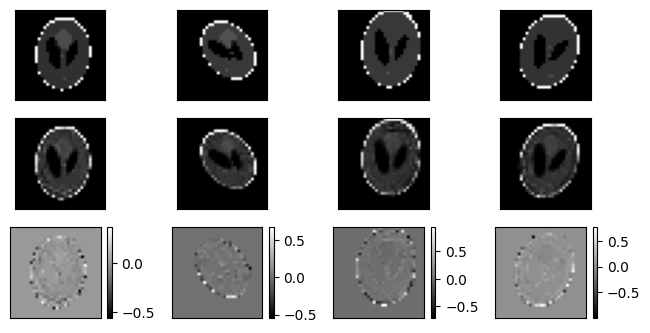

Frobenius Norm of Difference Between Predicted and Target Input
1.9218464164323588
1.97853780039871
3.3837428175895417
2.903675364781303

Average Error (Fro norm of difference between target and reconstruction)
2.730402825823605


In [ ]:
# #load model from save

autoencoder = keras.models.load_model('models/SL_ae_ta')
encoder = keras.models.load_model('models/SL_e_ta')
decoder = keras.models.load_model('models/SL_d_ta')  

EXS = 4
rand_examples = []
for k in range(EXS):
  rand_examples.append(random.randint(0,n_test))

bce_Errs = []

#create and display model output
encoded_img = encoder.predict(target_test)
decoded_img = decoder.predict(encoded_img)
plt.figure(figsize=(8, 4))
for j in range(EXS):
    i = rand_examples[j]
    plt.gray()
    # Display five random original images
    ax = plt.subplot(3, EXS, j + 1)
    plt.imshow(target_test[i].reshape((target_size[0], target_size[1]),order="F"))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display the reconstructions of the five original (autoencoder outputs)
    ax = plt.subplot(3, EXS, j + 1 + EXS)
    plt.imshow(decoded_img[i].reshape((target_size[0], target_size[1]),order="F"))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display five errors
    ax = plt.subplot(3, EXS, j + 1 + EXS + EXS)
    err = target_test[i].reshape((target_size[0],target_size[1]),order="F")-decoded_img[i].reshape((target_size[0], target_size[1]),order="F")
    plt.imshow(err)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    bce_Errs.append(linalg.norm(err))
    plt.colorbar()
plt.savefig('figures/target_ae.eps', format='eps')
plt.show()

print('Frobenius Norm of Difference Between Predicted and Target Input')
for i in range(EXS):
  print(str(bce_Errs[i]))

  errs = []

for i in range(n_test):
  err = target_test[i].reshape(target_size[0],target_size[1])-decoded_img[i].reshape(target_size[0], target_size[1])
  errs.append(linalg.norm(err))
print('\nAverage Error (Fro norm of difference between target and reconstruction)')
print(statistics.mean(errs))

## Inversion and Forward Progagation through RON

In [ ]:
b_encoder = keras.models.load_model('models/SL_e_in')
latent_input_train = b_encoder.predict(input_train)
latent_input_test = b_encoder.predict(input_test)


x_encoder = keras.models.load_model('models/SL_e_ta')
latent_target_train = x_encoder.predict(target_train)
latent_target_test = x_encoder.predict(target_test)

forward = np.transpose(latent_input_train) @ np.transpose(linalg.pinv(latent_target_train))
inverse = np.transpose(latent_target_train) @ np.transpose(linalg.pinv(latent_input_train))
np.save('models/forward_map_l15',forward)
np.save('models/inverse_map_l15',inverse)

63/63 [==============================] - 0s 1ms/step


63/63 [==============================] - 0s 3ms/step


63/63 [==============================] - 0s 2ms/step
3.463512383044846
3.9086391314125817
4.694597822089631
3.582955902814501


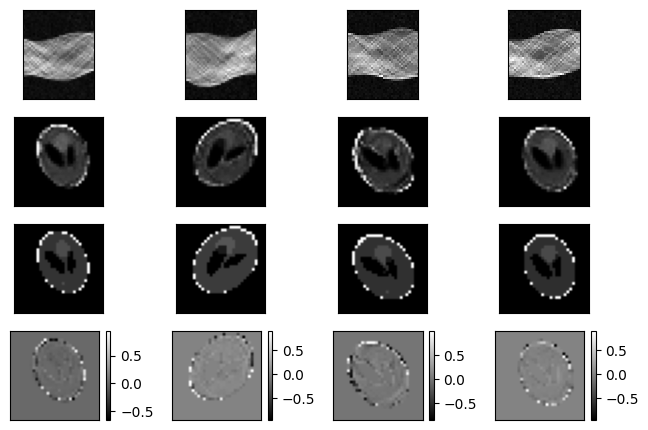


Average Error (Fro norm of difference between target and reconstruction)
0.663274517094062


In [ ]:
# #load bce model from save
reconstructed_latent_x = inverse @ np.transpose(latent_input_test)
x_decoder = keras.models.load_model('models/SL_d_ta')
reconstructed_x = x_decoder.predict(np.transpose(reconstructed_latent_x))

EXS = 4
rand_examples = []
for k in range(EXS):
  rand_examples.append(random.randint(0,n_test))

#create and display model output
plt.figure(figsize=(8, 5.33))
for j in range(EXS):
    i = rand_examples[j]
    plt.gray()
    # Display five random original inputs images
    ax = plt.subplot(4, EXS, j + 1)
    plt.imshow(input_test[i].reshape((input_size[0], input_size[1]),order="F"))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display the reconstructions of the five original (autoencoder outputs)
    ax = plt.subplot(4, EXS, j + 1 + EXS)
    plt.imshow(reconstructed_x[i].reshape((target_size[0], target_size[1]),order="F"))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display five random original images
    ax = plt.subplot(4, EXS, j + 1 + EXS + EXS)
    plt.imshow(target_test[i].reshape((target_size[0], target_size[1]),order="F"))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display five random original images
    ax = plt.subplot(4, EXS, j + 1 + EXS + EXS + EXS)
    err = target_test[i].reshape((target_size[0], target_size[1]),order="F") - reconstructed_x[i].reshape((target_size[0], target_size[1]),order="F")
    plt.imshow(err)
    print(linalg.norm(err))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.colorbar()
plt.savefig('figures/PAN_inversion.eps', format='eps')
plt.show()

errs = []

for i in range(n_test):
  err = target_test[i].reshape((target_size[0], target_size[1]),order="F") - reconstructed_x[i].reshape((target_size[0], target_size[1]),order="F")
  errs.append(linalg.norm(err)/linalg.norm(target_test[i].reshape((target_size[0], target_size[1]),order="F")))
print('\nAverage Error (Fro norm of difference between target and reconstruction)')
print(statistics.mean(errs))


63/63 [==============================] - 0s 2ms/step


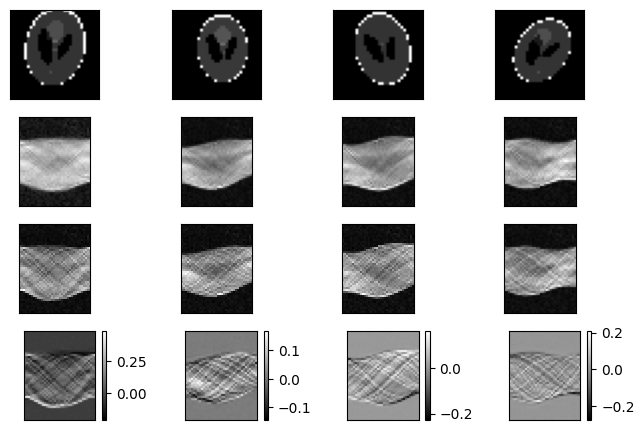


Average Error (Fro norm of difference between target and reconstruction)
0.1866814832354984


In [ ]:
# #load bce model from save
b_decoder = keras.models.load_model('models/SL_d_in')

reconstructed_latent_b = forward @ np.transpose(latent_target_test)
reconstructed_b = b_decoder.predict(np.transpose(reconstructed_latent_b))

EXS = 4
rand_examples = []
for k in range(EXS):
  rand_examples.append(random.randint(0,n_test))

#create and display model output
plt.figure(figsize=(8, 5.33))
for j in range(EXS):
    i = rand_examples[j]
    plt.gray()
    # Display five random original target images
    ax = plt.subplot(4, EXS, j + 1)
    plt.imshow(target_test[i].reshape((target_size[0], target_size[1]),order="F"))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display the reconstructions of the five original (autoencoder outputs)
    ax = plt.subplot(4, EXS, j + 1 + EXS)
    plt.imshow(reconstructed_b[i].reshape((input_size[0], input_size[1]),order="F"))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display the five random original images
    ax = plt.subplot(4, EXS, j + 1 + EXS + EXS)
    plt.imshow(input_test[i].reshape((input_size[0], input_size[1]),order="F"))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display five random original images
    ax = plt.subplot(4, EXS, j + 1 + EXS + EXS + EXS)
    err = input_test[i].reshape((input_size[0], input_size[1]),order="F") - reconstructed_b[i].reshape((input_size[0], input_size[1]),order="F")
    plt.imshow(err)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.colorbar()
plt.savefig('figures/PAN_propagation.eps', format='eps')
plt.show()

errs = []

for i in range(n_test):
  err = input_test[i].reshape((input_size[0], input_size[1]),order="F") - reconstructed_b[i].reshape((input_size[0], input_size[1]),order="F")
  errs.append(linalg.norm(err)/linalg.norm(input_test[i].reshape((input_size[0], input_size[1]),order="F")))
print('\nAverage Error (Fro norm of difference between target and reconstruction)')
print(statistics.mean(errs))

## Fully Learned Inversion

In [ ]:
#creating full four layer inversion network

#define dimension of the latent space and inner dimension for the second layer
latent_dim = 15
inner_dim = int((input_length+latent_dim)/2)

#establish architecture of the encoder
encoder_input = keras.Input(shape = input_length, name = 'original_image')
inner_encoded = layers.Dense(inner_dim, activation = 'relu', 
                             activity_regularizer = keras.regularizers.l1(10e-6),
                             kernel_initializer='random_normal',
                             bias_initializer='zeros')(encoder_input)
encoder_output = layers.Dense(latent_dim, activation = 'linear',
                              activity_regularizer = keras.regularizers.l1(10e-6),
                              kernel_initializer='random_normal',
                              bias_initializer='zeros')(inner_encoded)

encoder = keras.Model(encoder_input, encoder_output, name = 'encoder')
encoder.summary()

#establish architecture of the decoder
inner_dim = int((target_length+latent_dim)/2)
decoder_input = keras.Input(shape = latent_dim, name = 'encoded_image')
inner_decoded = layers.Dense(inner_dim, activation = 'relu',
                             activity_regularizer = keras.regularizers.l1(10e-6),
                             kernel_initializer='random_normal',
                             bias_initializer='zeros')(decoder_input)
decoder_output = layers.Dense(target_length, activation = 'sigmoid',
                              activity_regularizer = keras.regularizers.l1(10e-6),
                              kernel_initializer='random_normal',
                              bias_initializer='zeros')(inner_decoded)
decoder = keras.Model(decoder_input, decoder_output, name = 'decoder')
decoder.summary()

#create full encoder_decoder model
encoder_decoder_input = keras.Input(shape = input_length, name = 'original_image')
encoded_image = encoder(encoder_decoder_input)
decoded_image = decoder(encoded_image)
encoder_decoder = keras.Model(encoder_decoder_input, decoded_image, name = 'encoder_decoder')
encoder_decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 original_image (InputLayer)  [(None, 1620)]           0         
                                                                 
 dense_8 (Dense)             (None, 817)               1324357   
                                                                 
 dense_9 (Dense)             (None, 15)                12270     
                                                                 
Total params: 1,336,627
Trainable params: 1,336,627
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoded_image (InputLayer)  [(None, 15)]              0         
                                                                 
 dense_10 (Dense)            (No

In [ ]:
# compiling encoder_decoder
encoder_decoder.compile(optimizer='adam', loss= 'binary_crossentropy')       
encoder_decoder.fit(input_train, target_train,
                epochs=200,
                batch_size=256,
                validation_data=(input_test, target_test))
encoder_decoder.save('models/SL_encoder_decoder')

Epoch 1/200
40/40 [==============================] - 2s 12ms/step - loss: 0.3253 - val_loss: 0.2502
Epoch 2/200
40/40 [==============================] - 0s 6ms/step - loss: 0.2466 - val_loss: 0.2444
Epoch 3/200
40/40 [==============================] - 0s 6ms/step - loss: 0.2417 - val_loss: 0.2382
Epoch 4/200
40/40 [==============================] - 0s 6ms/step - loss: 0.2337 - val_loss: 0.2298
Epoch 5/200
40/40 [==============================] - 0s 7ms/step - loss: 0.2252 - val_loss: 0.2197
Epoch 6/200
40/40 [==============================] - 0s 6ms/step - loss: 0.2161 - val_loss: 0.2129
Epoch 7/200
40/40 [==============================] - 0s 6ms/step - loss: 0.2108 - val_loss: 0.2089
Epoch 8/200
40/40 [==============================] - 0s 7ms/step - loss: 0.2072 - val_loss: 0.2059
Epoch 9/200
40/40 [==============================] - 0s 6ms/step - loss: 0.2045 - val_loss: 0.2039
Epoch 10/200
40/40 [==============================] - 0s 9ms/step - loss: 0.2025 - val_loss: 0.2019
Epoch 11

63/63 [==============================] - 0s 3ms/step
2.6834878167599383
1.979623145690095
2.5800846455383954
2.2842098954821126


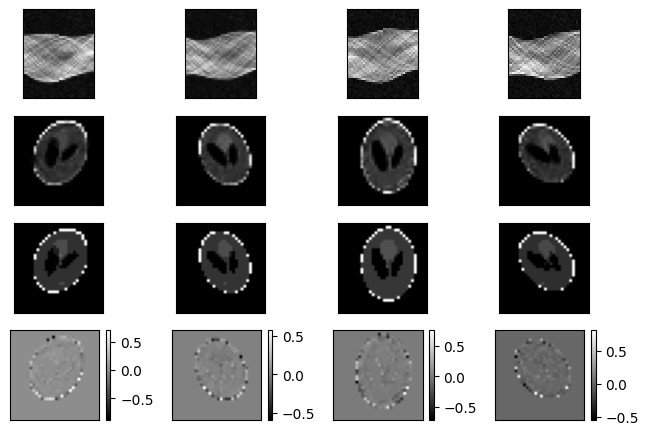


Average Error (Fro norm of difference between target and reconstruction)
0.2901446862365865


In [ ]:
# #load bce model from save
encoder_decoder = keras.models.load_model('models/SL_encoder_decoder')
reconstructed_x = encoder_decoder.predict(input_test)

EXS = 4
rand_examples = []
for k in range(EXS):
  rand_examples.append(random.randint(0,n_test))

#create and display model output
plt.figure(figsize=(8, 5.33))
for j in range(EXS):
    i = rand_examples[j]
    plt.gray()
    # Display five random original inputs images
    ax = plt.subplot(4, EXS, j + 1)
    plt.imshow(input_test[i].reshape((input_size[0], input_size[1]),order="F"))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display the reconstructions of the five original (autoencoder outputs)
    ax = plt.subplot(4, EXS, j + 1 + EXS)
    plt.imshow(reconstructed_x[i].reshape((target_size[0], target_size[1]),order="F"))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display five random original images
    ax = plt.subplot(4, EXS, j + 1 + EXS + EXS)
    plt.imshow(target_test[i].reshape((target_size[0], target_size[1]),order="F"))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display five random original images
    ax = plt.subplot(4, EXS, j + 1 + EXS + EXS + EXS)
    err = target_test[i].reshape((target_size[0], target_size[1]),order="F") - reconstructed_x[i].reshape((target_size[0], target_size[1]),order="F")
    plt.imshow(err)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    print(linalg.norm(err))
    plt.colorbar()
plt.savefig('figures/nn_inversion.eps', format='eps')
plt.show()

for i in range(n_test):
  err = target_test[i].reshape((target_size[0], target_size[1]),order="F") - reconstructed_x[i].reshape((target_size[0], target_size[1]),order="F")
  errs.append(linalg.norm(err)/linalg.norm(target_test[i].reshape((target_size[0], target_size[1]),order="F")))
print('\nAverage Error (Fro norm of difference between target and reconstruction)')
print(statistics.mean(errs))


## Noise Propagation

In [ ]:
mat2 = scipy.io.loadmat('data/SheppLoganData_20noise.mat')
mat2.keys()
B = mat2['B']
X = mat2['X']
Xn = mat2['X_n']
X = X.reshape((1, 1024),order="F")
Xn = Xn.reshape((10000,1024),order="F")

x_encoder = keras.models.load_model('models/SL_e_ta')
# b_encoder = keras.models.load_model('models/SL_e_in')

b_decoder = keras.models.load_model('models/SL_d_in')
# x_decoder = keras.models.load_model('models/SL_d_ta')

313/313 [==============================] - 1s 2ms/step
Noisy  X Latent Variable Distributions


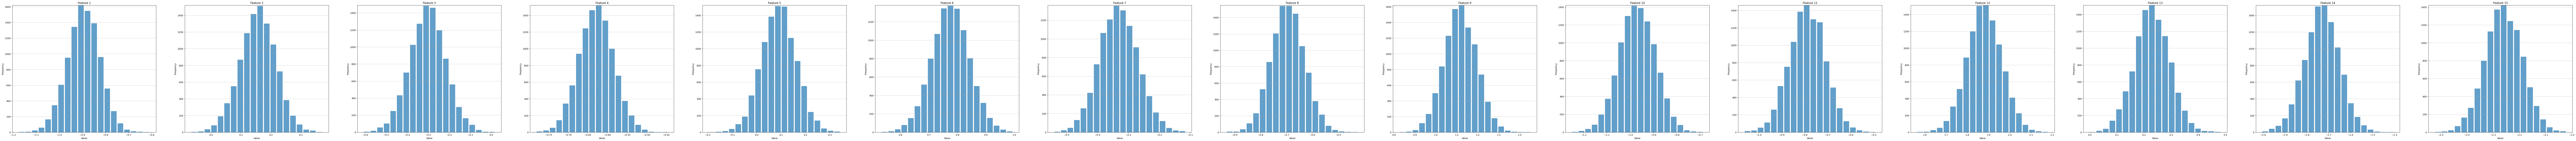

In [ ]:
# Through RON
latent_noisy_x = x_encoder.predict(Xn)
latent_noisy_b = forward @ np.transpose(latent_noisy_x)
noisy_b_reconstruction = b_decoder.predict(np.transpose(latent_noisy_b))
latent_noisy_x = np.transpose(latent_noisy_x)

# Noisy X Latent Variable Distributions
print('Noisy  X Latent Variable Distributions')
plt.figure(figsize=(200, 10))
for i in range(15):
  ax = plt.subplot(1, 15, i+1)
  feature = latent_noisy_x[i,:]
  n, bins, patches = plt.hist(x=feature, bins=20, alpha=0.7, rwidth=0.85)
  plt.grid(axis='y', alpha=0.75)
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.title('Feature ' + str(i+1))
  maxfreq = n.max()
  plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

## Inverse Problem with RON Regularization

63/63 [==============================] - 0s 1ms/step


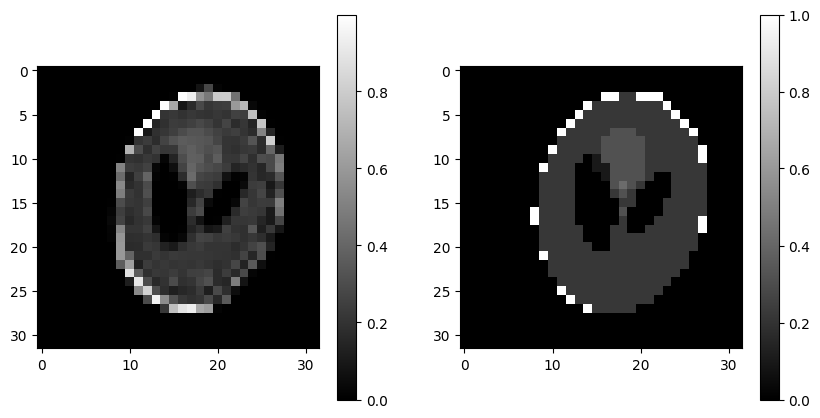

In [ ]:
b_encoder = keras.models.load_model('models/SL_e_in')
x_decoder = keras.models.load_model('models/SL_d_ta')
inverse = np.load('models/inverse_map_l15.npy')

latent_input_test = b_encoder.predict(input_test)
reconstructed_latent_x = inverse @ np.transpose(latent_input_test)
reconstructed_x = x_decoder.predict(np.transpose(reconstructed_latent_x))

rand_ex = random.randint(0,n_test)
b = input_test[rand_ex,:]
x_guess = reconstructed_x[rand_ex]
x_true = target_test[rand_ex]

plt.figure(figsize=(10, 5))
CHECK = x_guess
ax = plt.subplot(1, 2, 1)
plt.imshow(CHECK.reshape((target_size[0], target_size[1]),order='F'))
plt.colorbar()
CHECK = x_true
ax = plt.subplot(1, 2, 2)
plt.imshow(CHECK.reshape((target_size[0], target_size[1]),order='F'))
plt.colorbar()

plt.show()

[0.02653591 0.00968396 0.00705587 ... 0.00939856 0.00829891 0.03249918]
528
0.962169679167217


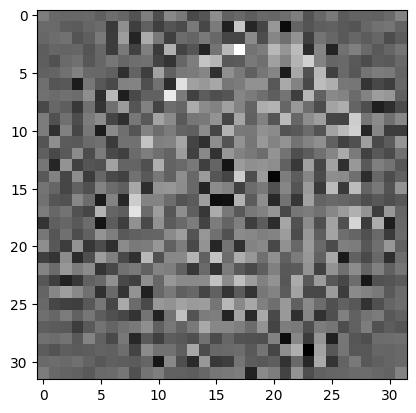

In [ ]:
# Without regularization, initial guess all zeros
b = np.transpose(input_test[rand_ex,:])
b = b.reshape((1620,1))

result, istop, itn, normr = scipy.sparse.linalg.lsqr(A,b)[:4]

print(result)
print(itn)
print(normr)
plt.imshow(result.reshape((target_size[0], target_size[1]),order="F"))

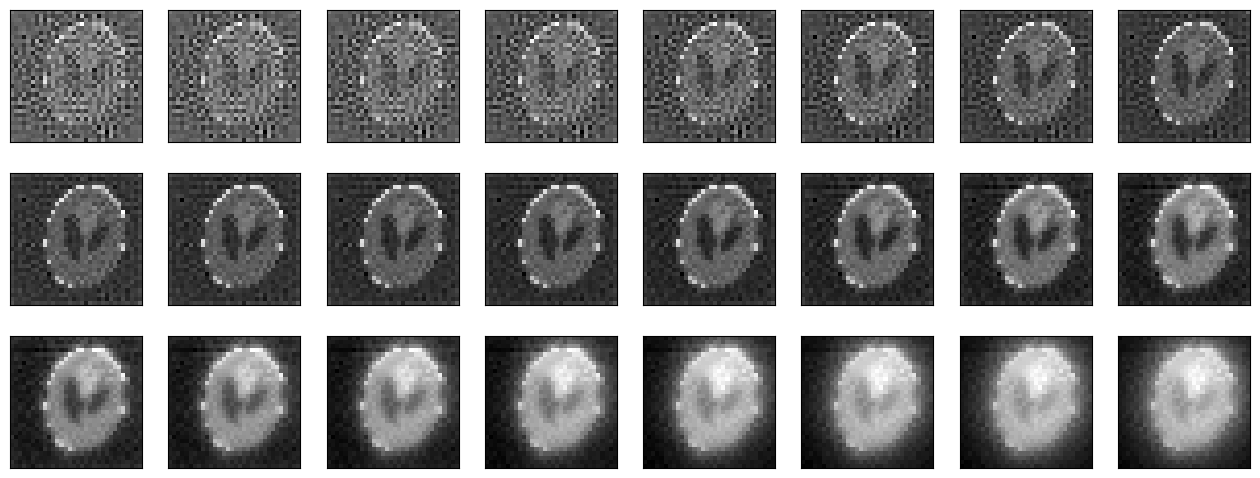

<ipython-input-33-3dffdd9e9f4f>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in current_values])


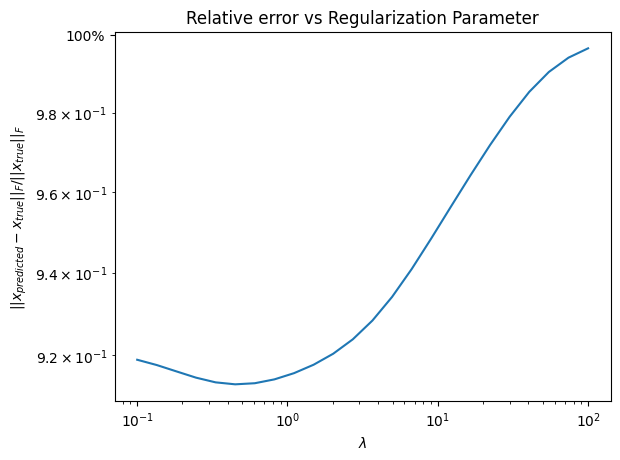

In [ ]:
# Tikhonov Regularization
b = np.transpose(input_test[rand_ex,:])
b = b.reshape((1620,1))
lambs = np.logspace(-1,2,24)

errs = []
plt.figure(figsize=(16,6))
for i in range(24):
  lamb = lambs[i]
  ax = plt.subplot(3,8,i+1)
  result_tik, istop, itn, normr = scipy.sparse.linalg.lsqr(A,b, damp=lamb)[:4]
  plt.imshow(result_tik.reshape((target_size[0], target_size[1]),order="F"))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  err = linalg.norm(result_tik-x_true) / linalg.norm(x_true)
  errs.append(err)
plt.show()
plt.savefig('figures/tik_varied_lam.png', format='png')

plt.loglog(lambs,errs)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in current_values])
plt.title('Relative error vs Regularization Parameter')
plt.xlabel('$\lambda$')
plt.ylabel('$||x_{predicted} - x_{true}||_F/||x_{true}||_F$')
plt.savefig('figures/tik_varied_lam_err.png', format='png')



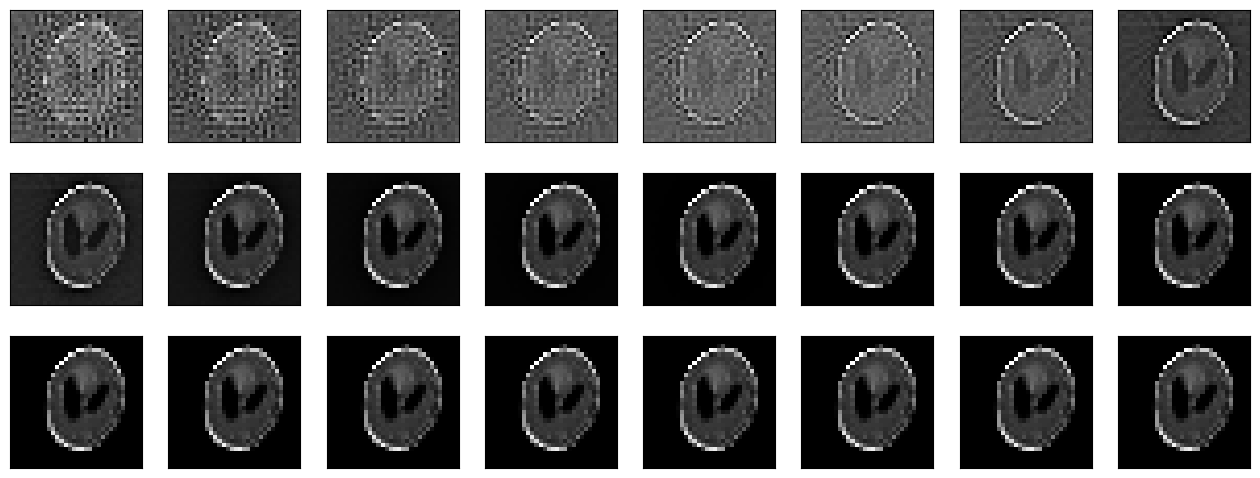

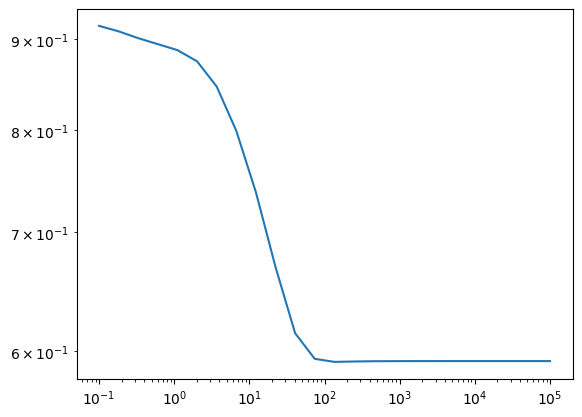

In [ ]:
# RON Regularization
b = np.transpose(input_test[rand_ex,:])
b = b.reshape((1620,1))
x_pred = reconstructed_x[rand_ex]

lambs = np.logspace(-1,5,24)

errs = []
plt.figure(figsize=(16,6))
for i in range(24):
  lamb = lambs[i]
  ax = plt.subplot(3,8,i+1)
  result_RON, istop, itn, normr = scipy.sparse.linalg.lsqr(A,b, damp=lamb, x0 = x_pred)[:4]
  plt.imshow(result_RON.reshape((target_size[0], target_size[1]),order="F"))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  err = linalg.norm(result_RON-x_true) / linalg.norm(x_true)
  errs.append(err)
plt.show()
plt.savefig('figures/tik_varied_lam.png', format='png')

plt.loglog(lambs,errs)

# print(result)
# plt.imshow(result.reshape((target_size[0], target_size[1]),order="F"))

In [ ]:
# RON Regularization and Tikhonov?
b = np.transpose(input_test[rand_ex,:])
b = b.reshape((1620,1))
x_pred = reconstructed_x[rand_ex]

lambs = np.logspace(-1,5,24)

errs = []
plt.figure(figsize=(16,6))
for i in range(24):
  lamb = lambs[i]
  ax = plt.subplot(3,8,i+1)
  result_RON, istop, itn, normr = scipy.sparse.linalg.lsqr(A,b, damp=lamb, x0 = x_pred)[:4]
  plt.imshow(result_RON.reshape((target_size[0], target_size[1]),order="F"))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  err = linalg.norm(result_RON-x_true) / linalg.norm(x_true)
  errs.append(err)
plt.show()
plt.savefig('figures/tik_varied_lam.png', format='png')

plt.loglog(lambs,errs)

# print(result)
# plt.imshow(result.reshape((target_size[0], target_size[1]),order="F"))

## Checks/Plotting

In [ ]:
# # Plotting Checks

# ## # Insanity check that these are correct pairs
# ## print(input_obsv)
# ## print(input_obsv.shape)
# ## print(x_guess)
# ## print(x_guess.shape)
# ## plt.imshow(input_obsv.reshape(input_size[0], input_size[1]))
# ## plt.show
# ## plt.imshow(x_guess.reshape(target_size[0], target_size[1]))
# ## plt.show

# plt.figure(figsize=(20, 5))

# CHECK = A @ x_true
# ax = plt.subplot(1, 4, 1)
# plt.imshow(CHECK.reshape((input_size[0], input_size[1]),order='F'))
# plt.colorbar()
# # ax.get_xaxis().set_visible(False)
# # ax.get_yaxis().set_visible(False)

# CHECK = np.transpose(A @ x_guess)
# ax = plt.subplot(1, 4, 2)
# plt.imshow(CHECK.reshape((input_size[0], input_size[1]),order='F'))
# plt.colorbar()
# # ax.get_xaxis().set_visible(False)
# # ax.get_yaxis().set_visible(False)

# # CHECK = b
# # ax = plt.subplot(1, 4, 3)
# # plt.imshow(CHECK.reshape((input_size[0], input_size[1]),order='F'))
# # plt.colorbar()
# # # ax.get_xaxis().set_visible(False)
# # # ax.get_yaxis().set_visible(False)

# CHECK = x_guess
# ax = plt.subplot(1, 4, 3)
# plt.imshow(CHECK.reshape((target_size[0], target_size[1]),order='F'))
# plt.colorbar()

# CHECK = x_true
# ax = plt.subplot(1, 4, 4)
# plt.imshow(CHECK.reshape((target_size[0], target_size[1]),order='F'))
# plt.colorbar()

# plt.show()


In [ ]:
linalg.norm(A @ np.transpose(target_train[1,:]) - np.transpose(input_train[1,:]))

133.6369506438882

In [ ]:
plt.figure(figsize=(20, 5))

CHECK = np.transpose(target_test[1,:])
ax = plt.subplot(1, 4, 1)
plt.imshow(CHECK.reshape((target_size[0], target_size[1]),order='F'))
plt.colorbar()
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)

# CHECK = np.transpose(A @ x_guess)
# ax = plt.subplot(1, 4, 2)
# plt.imshow(CHECK.reshape((input_size[0], input_size[1]),order='F'))
# plt.colorbar()
# # ax.get_xaxis().set_visible(False)
# # ax.get_yaxis().set_visible(False)


CHECK = np.transpose(input_train[1,:])
ax = plt.subplot(1, 4, 3)
plt.imshow(CHECK.reshape((input_size[0], input_size[1]),order='F'))
plt.colorbar()
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)

plt.show()